<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="https://sebastianraschka.com">Sebastian Raschka</a>의 저서 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 보충 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="images/llm_from_scratch/ch06_compressed/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# LoRA를 이용한 파라미터 효율적 미세 조정(Finetuning)

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        # "tensorflow", # OpenAI의 사전 훈련된 가중치를 로드하기 위함
        "pandas"      # 데이터셋 로딩용
       ]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.8
numpy 버전: 2.4.0
tiktoken 버전: 0.12.0
torch 버전: 2.9.1+cu126
pandas 버전: 2.3.3


## E.1 LoRA 소개

- 이 섹션에는 코드가 없습니다.
- 저차원 적응(Low-rank adaptation, LoRA)은 모델 파라미터 중 작고 낮은 랭크(low-rank)를 가진 일부 하위 집합만 조정하여, 사전 훈련된 모델을 특정 데이터셋(주로 작은 데이터셋)에 더 잘 맞도록 수정하는 머신러닝 기법입니다.
- 이 접근 방식은 대규모 모델을 특정 작업 데이터에 맞춰 효율적으로 미세 조정할 수 있게 해주며, 미세 조정에 필요한 계산 비용과 시간을 크게 줄여준다는 점에서 중요합니다.

- 주어진 레이어에 대한 거대한 가중치 행렬 $W$가 있다고 가정해 봅시다.
- 역전파(backpropagation) 동안 우리는 $\Delta W$ 행렬을 학습하게 되는데, 이 행렬은 훈련 중 손실 함수를 최소화하기 위해 원래 가중치를 얼마나 업데이트해야 하는지에 대한 정보를 담고 있습니다.
- 일반적인 훈련 및 미세 조정에서 가중치 업데이트는 다음과 같이 정의됩니다:

$$W_{\text{updated}} = W + \Delta W$$

- [Hu 등](https://arxiv.org/abs/2106.09685)이 제안한 LoRA 방법은 $\Delta W$의 근사치인 $\Delta W \approx AB$를 학습함으로써 가중치 업데이트를 계산하는 더 효율적인 대안을 제공합니다.
- 즉, LoRA에서는 두 개의 작은 가중치 행렬 $A$와 $B$를 사용하여 다음과 같이 나타냅니다:

$$W_{\text{updated}} = W + AB$$

- 아래 그림은 전체 미세 조정(full finetuning)과 LoRA의 공식을 나란히 비교하여 보여줍니다.

<img src="images/llm_from_scratch/appendix-e_compressed/lora-1.webp" width="500px">

- 자세히 살펴보면 위 그림의 전체 미세 조정과 LoRA 묘사가 앞서 보여드린 공식과 약간 다르게 보일 수 있습니다.
- 이는 행렬 곱셈의 분배 법칙 때문입니다. 가중치와 업데이트 가중치를 더할 필요 없이 별도로 유지할 수 있습니다.
- 예를 들어 $x$가 입력 데이터라면, 일반적인 미세 조정에 대해 다음과 같이 쓸 수 있습니다:

$$x (W+\Delta W) = x W + x \Delta W$$

- 마찬가지로 LoRA에 대해서도 다음과 같이 쓸 수 있습니다:

$$x (W+A B) = x W + x A B$$

- LoRA 가중치 행렬을 별도로 유지할 수 있다는 점이 LoRA를 특히 매력적으로 만듭니다.
- 실제 적용 시, 이는 사전 훈련된 모델의 가중치를 전혀 수정할 필요가 없음을 의미하며, 필요할 때 실시간으로(on the fly) LoRA 행렬을 적용할 수 있습니다.
- 데이터셋을 설정하고 모델을 로드한 후, 이러한 개념들이 덜 추상적으로 느껴지도록 코드로 LoRA를 구현해 보겠습니다.

## E.2 데이터셋 준비하기

- 이 섹션은 데이터셋을 로드하고 준비하기 위해 6장의 코드를 반복합니다.
- 코드를 반복하는 대신 6장 노트북을 열어 실행한 다음, 그곳에 섹션 E.4의 LoRA 코드를 삽입할 수도 있습니다.
- (LoRA 코드는 원래 6장의 마지막 섹션이었으나 6장의 분량 문제로 인해 부록으로 이동되었습니다.)
- 이와 유사한 방식으로 7장의 모델들에 LoRA를 적용하여 명령 미세 조정(instruction finetuning)을 수행할 수도 있습니다.

In [1]:
# import urllib
import requests
from pathlib import Path
import pandas as pd
from previous_chapters import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "datas/sms_spam_collection.zip"
extracted_path = "datas/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"기본 URL 실패: {e}. 백업 URL 시도 중...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("datas/train.csv", index=None)
validation_df.to_csv("datas/validation.csv", index=None)
test_df.to_csv("datas/test.csv", index=None)

datas\sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
import torch
import tiktoken
from previous_chapters import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("datas/train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("datas/validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("datas/test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [3]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- 검증 단계로, 데이터 로더를 순회하며 각 배치가 8개의 훈련 사례를 포함하고 각 사례가 120개의 토큰으로 구성되어 있는지 확인합니다.

In [4]:
print("훈련 로더:")
for input_batch, target_batch in train_loader:
    pass

print("입력 배치 차원:", input_batch.shape)
print("레이블 배치 차원", target_batch.shape)

훈련 로더:
입력 배치 차원: torch.Size([8, 120])
레이블 배치 차원 torch.Size([8])


- 마지막으로, 각 데이터셋의 총 배치 수를 출력해 봅니다.

In [5]:
print(f"{len(train_loader)}개 훈련 배치")
print(f"{len(val_loader)}개 검증 배치")
print(f"{len(test_loader)}개 테스트 배치")

130개 훈련 배치
19개 검증 배치
38개 테스트 배치


## E.3 모델 초기화하기

- 이 섹션은 모델을 로드하고 준비하기 위해 6장의 코드를 반복합니다.

In [6]:
from previous_chapters import GPTModel, load_gpt2_model
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12}, #트랜스포머 블록(Transformer Block)을 몇 층으로 쌓아 올렸는지
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_name = "gpt2-small-124M.pth"
model = load_gpt2_model(model_name, BASE_CONFIG)
model.eval()

이미 파일이 존재합니다: models/gpt2\gpt2-small-124M.pth


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 모델이 올바르게 로드되었는지 확인하기 위해, 일관성 있는 텍스트를 생성하는지 다시 한 번 체크합니다.

In [7]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 그런 다음, 6장과 유사하게 출력 레이어를 교체하여 분류 미세 조정을 위한 모델을 준비합니다.

In [8]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")

print("사용 장치:", device)

model.to(device);  # nn.Module 클래스의 경우 model = model.to(device)와 같은 할당이 필요 없습니다.

사용 장치: cuda


- 마지막으로, 미세 조정되지 않은 모델의 초기 분류 정확도를 계산해 봅니다. (약 50% 정도를 예상하며, 이는 모델이 아직 스팸과 일반 메시지를 안정적으로 구분하지 못함을 의미합니다.)

In [11]:
from previous_chapters import calc_accuracy_loader
# 대안:
# from llms_from_scratch.ch06 import calc_accuracy_loader



torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


## E.4 LoRA를 이용한 파라미터 효율적 미세 조정

- 먼저 행렬 $A$와 $B$를 생성하는 `LoRALayer`를 초기화합니다. 여기에는 `alpha` 스케일링 하이퍼파라미터와 `rank` ($r$) 하이퍼파라미터가 포함됩니다.
- 이 레이어는 아래 그림과 같이 입력을 받아 그에 상응하는 출력을 계산할 수 있습니다.

<img src="images/llm_from_scratch/appendix-e_compressed/lora-2.webp" width="500px">

코드에서 위 그림의 LoRA 레이어는 다음과 같이 구현됩니다.

In [13]:
import math
import torch

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        """
        LoRA(Low-Rank Adaptation) 레이어 초기화
        
        Args:
            in_dim: 입력 데이터의 차원 크기 (예: 768)
            out_dim: 출력 데이터의 차원 크기 (예: 768)
            rank: 병목 구간의 크기 (Rank, r). 작을수록 파라미터가 적어짐 (예: 8, 16)
            alpha: 스케일링 상수. 학습된 값의 영향력을 조절함
        """
        super().__init__()
        
        # 1. 행렬 A (Down-projection)
        # 입력(in_dim)을 작은 차원(rank)으로 압축하는 가중치입니다.
        # 파라미터로 등록하여 학습되도록 합니다.
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        
        # A는 무작위 값(Kaiming Uniform)으로 초기화합니다.
        # 이렇게 해야 다양한 특징을 학습할 준비가 됩니다.
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        
        # 2. 행렬 B (Up-projection)
        # 압축된 정보(rank)를 다시 원래 출력 차원(out_dim)으로 복원하는 가중치입니다.
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        
        # 중요: B는 '0'으로 초기화합니다.
        # 이유: 학습 시작 시점에는 A @ B의 결과가 0이 되어야 합니다.
        # 그래야 LoRA를 붙여도 기존 모델의 원래 출력값에 아무런 영향을 주지 않은 채로 시작할 수 있습니다.
        
        self.alpha = alpha
        self.rank = rank

    def forward(self, x):
        """
        순전파(Forward) 단계: 입력 x에 대한 LoRA 변화량(Delta)을 계산
        """
        # 1. 행렬 연산 (x @ A @ B)
        # 입력 x를 A와 곱해 차원을 줄이고(압축), 
        # 그 결과를 다시 B와 곱해 차원을 늘립니다(복원).
        # 연산 순서: (Batch, in) -> (Batch, rank) -> (Batch, out)
        
        # 2. 스케일링 (alpha / rank)
        # 학습된 결과에 상수배를 해줍니다. 
        # alpha는 강도 조절, rank로 나누는 것은 rank값이 바뀌어도 
        # 학습률(Learning Rate)을 크게 수정하지 않기 위한 정규화(Normalization) 과정입니다.
        x = (self.alpha / self.rank) * (x @ self.A @ self.B)
        
        return x

- 위의 코드에서 `rank`는 행렬 $A$와 $B$의 내부 차원을 제어하는 하이퍼파라미터입니다.
- 즉, 이 파라미터는 LoRA에 의해 도입되는 추가 파라미터의 수를 제어하며, 모델의 적응력과 파라미터 효율성 사이의 균형을 결정하는 핵심 요소입니다.
- 두 번째 하이퍼파라미터인 `alpha`는 저차원 적응의 출력에 적용되는 스케일링 하이퍼파라미터입니다.
- 이는 기본적으로 적응된 레이어의 출력이 적응 대상인 원래 레이어의 출력에 미치는 영향력을 조절합니다.
- 이는 저차원 적응이 레이어 출력에 주는 영향을 규제하는 방법으로 볼 수 있습니다.
- 지금까지 구현한 `LoRALayer` 클래스는 레이어 입력 $x$를 변환할 수 있게 해줍니다.
- 하지만 LoRA에서는 보통 아래 그림처럼 가중치 업데이트가 기존의 사전 훈련된 가중치에 적용되도록 기존의 `Linear` 레이어를 대체하는 데 관심이 있습니다.

<img src="images/llm_from_scratch/appendix-e_compressed/lora-3.webp" width="500px">

- 위 그림과 같이 원래의 `Linear` 레이어 가중치를 포함하기 위해, 아래에 `LinearWithLoRA` 레이어를 구현합니다. 이 레이어는 앞서 구현한 `LoRALayer`를 사용하며, 신경망(예: LLM의 자기 주의 모듈이나 피드 포워드 모듈) 내의 기존 `Linear` 레이어를 대체하는 데 사용될 수 있습니다.

In [ ]:
import torch

class LinearWithLoRA(torch.nn.Module):
    """
    기존의 Linear 레이어를 감싸서(Wrapping), 
    LoRA 어댑터를 추가한 새로운 복합 레이어를 만드는 클래스
    """
    def __init__(self, linear, rank, alpha):
        super().__init__()
        
        # 1. 기존 레이어 저장 (Frozen Weights)
        # 이미 학습된 레이어 가중치(W)를 그대로 가져옵니다.
        # 실제 사용 시에는 이 레이어의 가중치를 고정(freeze)시켜 학습되지 않게 합니다.
        self.linear = linear
        
        # 2. LoRA 레이어 생성 (Trainable Adapter)
        # 기존 레이어와 똑같은 입/출력 차원을 가지지만, 내부는 훨씬 가벼운 LoRA 레이어를 만듭니다.
        # linear.in_features, linear.out_features: 기존 레이어의 스펙을 그대로 베껴옵니다.
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        # 3. 결과 합치기 (The Core Logic)
        # 원래 모델이 하던 계산 결과 : self.linear(x)
        # LoRA가 새로 학습한 변화량 : self.lora(x)
        # 최종 결과 = 원래 결과 + 변화량
        return self.linear(x) + self.lora(x)

- 가중치 행렬 $B$(`LoRALayer` 내의 `self.B`)를 LoRA 레이어에서 0으로 초기화하기 때문에, $A$와 $B$의 행렬 곱셈 결과는 0으로 구성된 행렬이 되며 원래 가중치에 영향을 주지 않습니다. (원래 가중치에 0을 더해도 변하지 않기 때문입니다.)

- 앞서 정의한 GPT 모델에 LoRA를 시도해보기 위해, 모델 내의 모든 `Linear` 레이어를 새로운 `LinearWithLoRA` 레이어로 교체하는 `replace_linear_with_lora` 함수를 정의합니다.

<img src="images/llm_from_scratch/appendix-e_compressed/lora-4.webp" width="500px">

In [ ]:
import torch

def replace_linear_with_lora(model, rank, alpha):
    """
    모델 내의 모든 Linear 레이어를 찾아 LoRA가 적용된 레이어로 교체하는 재귀 함수
    
    Args:
        model: 수정할 파이토치 모델 (또는 모델의 하위 모듈)
        rank: LoRA의 Rank (r)
        alpha: LoRA의 Alpha (스케일링 계수)
    """
    
    # 1. 자식 모듈 순회 (Iterate Children)
    # named_children(): 현재 모듈 바로 아래에 있는 구성 요소들을 (이름, 객체) 쌍으로 가져옵니다.
    # 예: ("attn", AttentionModule), ("mlp", MLPModule) ...
    for name, module in model.named_children():
        
        # 2. 교체 대상 확인 (Check Target)
        # 현재 보고 있는 모듈이 'torch.nn.Linear'인지 확인합니다.
        # (즉, 우리가 LoRA를 붙이고 싶은 기본 선형 층인지 확인)
        if isinstance(module, torch.nn.Linear):
            
            # 3. 레이어 교체 (Swap Layer)
            # setattr(객체, 속성이름, 새로운값): 객체의 속성을 동적으로 변경하는 파이썬 내장 함수
            # model의 'name'에 해당하는 레이어를 -> 'LinearWithLoRA'로 덮어씌웁니다.
            # 이때 기존 module을 인자로 넘겨줘서 가중치를 그대로 보존하게 합니다.
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
            
        else:
            # 4. 재귀 호출 (Dig Deeper)
            # 만약 Linear 레이어가 아니라면(예: 트랜스포머 블록, 어텐션 층 등 컨테이너라면),
            # 그 내부에도 Linear 레이어가 숨어있을 수 있으므로
            # 그 안으로 들어가서 다시 똑같은 작업(replace_linear_with_lora)을 수행하라고 시킵니다.
            replace_linear_with_lora(module, rank, alpha)

- 그런 다음 원래 모델 파라미터를 동결(freeze)하고, 아래 코드를 사용하여 언급된 `Linear` 레이어들을 교체합니다.
- 이를 통해 LLM 내의 `Linear` 레이어들이 `LinearWithLoRA` 레이어로 바뀝니다.

In [ ]:
# 1. 현재 학습 가능한(Trainable) 파라미터 개수 계산
# - model.parameters(): 모델 내부의 모든 가중치(W)와 편향(b)을 가져옵니다.
# - p.numel(): 각 파라미터 텐서의 전체 원소 개수(Number of Elements)를 셉니다.
# - if p.requires_grad: 현재 '학습 대상(True)'으로 설정된 것들만 필터링합니다.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# {total_params:,} : 천 단위마다 쉼표(,)를 찍어서 보기 좋게 출력 (예: 1,000,000)
print(f"이전의 총 학습 가능 파라미터 수: {total_params:,}")


# 2. 모든 파라미터 얼리기 (Freezing)
# 모델의 모든 파라미터를 하나씩 꺼내서 반복합니다.
for param in model.parameters():
    # requires_grad = False:
    # "이 파라미터는 이제 학습시키지 마(기울기 계산 X)"라고 설정합니다.
    # 이렇게 하면 역전파(Backpropagation) 때 이 값들은 업데이트되지 않고 고정됩니다.
    param.requires_grad = False


# 3. 얼린 후 학습 가능 파라미터 수 재계산
# 위에서 모든 param의 requires_grad를 False로 바꿨으므로, 
# 조건(if p.requires_grad)을 만족하는 파라미터가 하나도 없게 됩니다.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# 결과적으로 0이 출력되어야 정상입니다.
print(f"이후의 총 학습 가능 파라미터 수: {total_params:,}")

이전의 총 학습 가능 파라미터 수: 124,441,346
이후의 총 학습 가능 파라미터 수: 0


In [16]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"총 학습 가능 LoRA 파라미터 수: {total_params:,}")

총 학습 가능 LoRA 파라미터 수: 2,666,528


- 보시다시피, LoRA를 사용함으로써 학습 가능한 파라미터 수를 거의 50배 줄였습니다.
- 이제 모델 아키텍처를 출력하여 레이어들이 의도한 대로 수정되었는지 다시 한 번 확인해 보겠습니다.

In [17]:
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

- 위의 모델 아키텍처를 보면, 모델이 이제 우리의 새로운 `LinearWithLoRA` 레이어들을 포함하고 있음을 알 수 있습니다.
- 또한, 행렬 $B$를 0으로 초기화했기 때문에 초기 모델 성능은 이전과 변함이 없을 것으로 기대합니다.

In [18]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


- 이제 흥미로운 부분인 미세 조정을 진행해 봅시다. 6장의 훈련 함수를 재사용합니다.
- 훈련은 M3 MacBook Air 노트북에서 약 15분 정도 소요되며, V100이나 A100 GPU에서는 30초도 걸리지 않습니다.

In [19]:
import time
from previous_chapters import train_classifier_simple

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련이 {execution_time_minutes:.2f}분 만에 완료되었습니다.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.346, Val loss 0.325
Ep 1 (Step 000100): Train loss 0.063, Val loss 0.144
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.054, Val loss 0.045
Ep 2 (Step 000200): Train loss 0.058, Val loss 0.122
Ep 2 (Step 000250): Train loss 0.041, Val loss 0.199
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.020, Val loss 0.153
Ep 3 (Step 000350): Train loss 0.019, Val loss 0.193
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.021, Val loss 0.084
Ep 4 (Step 000450): Train loss 0.005, Val loss 0.115
Ep 4 (Step 000500): Train loss 0.022, Val loss 0.115
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.013, Val loss 0.066
Ep 5 (Step 000600): Train loss 0.042, Val loss 0.029
Training accuracy: 100.00% | Validation accuracy: 95.00%
훈련이 1.08분 만에 완료되었습니다.


- 다양한 장치에서의 실행 시간은 다음과 같습니다.
  - 12.10분: MacBook M1 (CPU)
  - 2.16분: MacMini M4 Pro (MPS)
  - 3.50분: Jetson Nano (CUDA), 독자가 [공유](https://livebook.manning.com/forum?product=raschka&comment=581806)한 결과
  - 1.02분: DGX Spark (CUDA)

- 마지막으로 모델을 평가해 봅시다.

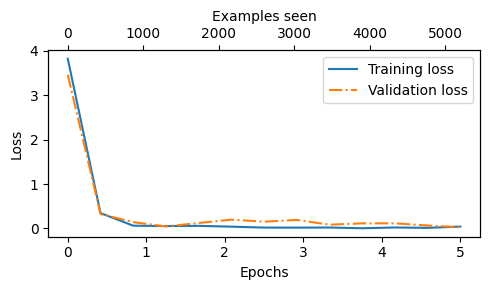

In [20]:
from previous_chapters import plot_values
# 대안:
# from llms_from_scratch.ch06 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

- 이전에는 `eval_iter=5` 설정을 통해 5개 배치에 대해서만 정확도를 계산했었습니다. 아래에서는 전체 데이터셋에 대해 정확도를 계산합니다.

In [21]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 99.81%
검증 정확도: 97.99%
테스트 정확도: 98.00%


- 위에서 확인한 상대적으로 높은 정확도 수치를 통해 LoRA 미세 조정이 성공적이었음을 알 수 있습니다.